# Coupling Coefficient Analysis

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
import matplotlib.colors as mcolors

sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import handy_roms_spec

import matplotlib as mpl
from dask.diagnostics import ProgressBar
warnings.filterwarnings("ignore")
from scipy.ndimage import generic_filter


In [2]:
from dask.diagnostics import ProgressBar
import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.distributed import Client, LocalCluster

# cluster = LocalCluster(n_workers=61)
# client = Client(cluster)

# client

In [3]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder

In [4]:
import seawater as sw
def grid_dist_same(lon,lat):
    import seawater as sw
    if len(lon.shape)==2:
        grid_x=np.zeros(lon.shape)+np.nan
    else:
        grid_x=np.zeros([lat.shape[0],lon.shape[0]])
    
    grid_d=sw.dist(lon=lon,lat=lat)[0]
    grid_x[0:-1,:]=grid_d
    grid_x[-1,:]=grid_d[-1,:]
    
    return grid_x

def area_filter(lon,lat,filter_scale,dim_x,dim_y):
    #paramerers for convolution
    if dim_x=='x_rho' and dim_y=='y_rho':
    
        grid=grid_dist_same(lon,lat)
        gs=xr.DataArray(grid,dims=(dim_y,dim_x))

        radius = int( (filter_scale / gs.min().compute() / 2 ).round()) 
        # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing
        window_size = 2 * radius + 1


        gsr = gs.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")

        gsr_lat = gsr.cumsum("lat_window")
        gsr_lat -= gsr_lat.isel(lat_window=radius)
        gsr_lon = gsr.cumsum("lon_window")
        gsr_lon -= gsr_lon.isel(lon_window=radius)
        circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < filter_scale / 2)
        Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])
    return gs,radius,circ,Asum

    
def apply_area_filter(var,gs,radius,circ,Asum):
    
    window_size = 2 * radius + 1
    
    var_sm = var.copy()
    var_sm += np.nan;



    varA  = gs ** 2 * var # multiplication with area
    varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
    var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
    var_sm_tmp2[radius:-radius,radius:-radius] = var_sm_tmp[radius:-radius,radius:-radius]
    var_sm[:] = var_sm_tmp2
    return var_sm


def apply_area_filter_t(var,gs,radius,circ,Asum):
    
    window_size = 2 * radius + 1
    
    var_sm = var.copy()
    var_sm += np.nan;



    varA  = gs ** 2 * var # multiplication with area
    varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
    var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
    var_sm_tmp2[:,radius:-radius,radius:-radius] = var_sm_tmp[:,radius:-radius,radius:-radius]
    var_sm[:] = var_sm_tmp2
    return var_sm
    



In [5]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

#### Reading CROCO files

In [6]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

#### Reading WRF files

In [7]:
chunks_new={'time_counter':40}

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'*DAY.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'*DAY.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[-7:],chunks=chunks_new)

#### Reading WRFout files

In [8]:

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listf_out=glob(path+'*out*');listf_out.sort()
varfout=xr.open_mfdataset(listf_out[-7:])

# path='/data/pacific/lrenault/SASI/SMTH/WRF/'
# listtw=glob(path+'*out*');listtw.sort()
# #vart=xr.open_dataset(listt[xmon])
# vartw=xr.open_mfdataset(listtw[-7:])

In [9]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

In [10]:
dxx=0.5

### Interpolating WRF variables

In [11]:
%%time
# chunks_new={'time_counter':40}

sst_w_f=regrid(varfw.SST,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

lh_f=regrid(varfw.LH,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
# lh_t=regrid(vartw.LH,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

sh_f=regrid(varfw.HFX,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
# sh_t=regrid(vartw.HFX,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

# swh_f=regrid(varfw.GSW,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] #net shortwave
# # swh_t=regrid(vartw.GSW,
# #                 lons=varf.nav_lon_rho.data,
# #                 lats=varf.nav_lat_rho.data,
# #                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] 


# glw_f=regrid(varfw.GLW,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] #downwelling long wave (needs to be subtract by S.Boltzman Law
# # glw_t=regrid(vartw.GLW,
# #                 lons=varf.nav_lon_rho.data,
# #                 lats=varf.nav_lat_rho.data,
# #                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 1min 11s, sys: 3.91 s, total: 1min 15s
Wall time: 1min 33s


#### Long wave heat flux component Calculation

In [12]:
# emss=1

# # lwh_f=(5.67e-8*(tw_f)**4 - glw_f)
# # lwh_t=(5.67e-8*(tw_t)**4 - glw_t)

# # lwh_f=(5.67e-8*(tf.data+273.15)**4 - glw_f)
# # lwh_t=(5.67e-8*(tt.data+273.15)**4 - glw_t)

# lwh_f= (5.67e-8*(sst_w_f.data)**4)*emss -glw_f
# # lwh_t=(5.67e-8*(tsk_t.data)**4 - glw_t)*emss

## Reading CROCO variables

In [13]:
%%time
chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean('time_counter')
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[:-1,1:-1,1:-1]


# tt=vart.temp.groupby("time_counter.dayofyear").mean()
# tt=tt.chunk(chunks=chunks_new);
# tt=tt[:,100:-100,100:-200].compute()
# tt=tt[:-1,1:-1,1:-1]


hf=varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,100:-100,100:-200].compute();
hf=hf[:-1,1:-1,1:-1]


# ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
# ht=ht.chunk(chunks=chunks_new);
# ht=ht[:,100:-100,100:-200].compute();
# ht=ht[:-1,1:-1,1:-1]

CPU times: user 19.1 s, sys: 11.7 s, total: 30.8 s
Wall time: 1min 30s


In [14]:
sh_f=sh_f.rename({'x': 'x_rho','y': 'y_rho'})

lh_f=lh_f.rename({'x': 'x_rho','y': 'y_rho'})

# lwh_f=lwh_f.rename({'x': 'x_rho','y': 'y_rho'})

# swh_f=swh_f.rename({'x': 'x_rho','y': 'y_rho'})

In [15]:
qh_f=(sh_f+lh_f).compute()

In [16]:
%%time
dec=3
tdec=1
tf=tf.compute()


tf_sm=tf[::tdec,::dec,::dec].copy()*np.nan
hf_sm=hf[::tdec,::dec,::dec].copy()*np.nan
qhf_sm=qh_f[::tdec,::dec,::dec].copy()*np.nan



CPU times: user 118 ms, sys: 1.03 ms, total: 119 ms
Wall time: 118 ms


In [17]:
%%time
wfl=100
counter=0
for tms in (tf.dayofyear-1).data[::tdec]:    
    tf_sm[counter,:,:]= xr.apply_ufunc(generic_filter,tf[tms,::dec,::dec], np.mean, [wfl,wfl])

    hf_sm[counter,:,:]= xr.apply_ufunc(generic_filter,hf[tms,::dec,::dec], np.mean, [wfl,wfl])

    qhf_sm[counter,:,:]= xr.apply_ufunc(generic_filter,qh_f[tms,::dec,::dec], np.mean, [wfl,wfl])
    counter+=1

CPU times: user 31min 37s, sys: 40.3 s, total: 32min 18s
Wall time: 32min 22s


In [18]:
rtf_f=(tf[::tdec,::dec,::dec]-tf_sm).data#[:,~np.isnan(tf_sm[0].data)]
rqf_f=(hf[::tdec,::dec,::dec]-hf_sm).data#[:,~np.isnan(hf_sm[0].data)]
rqhf_f=(qh_f[::tdec,::dec,::dec]-qhf_sm).data#[:,~np.isnan(hf_sm[0].data)]

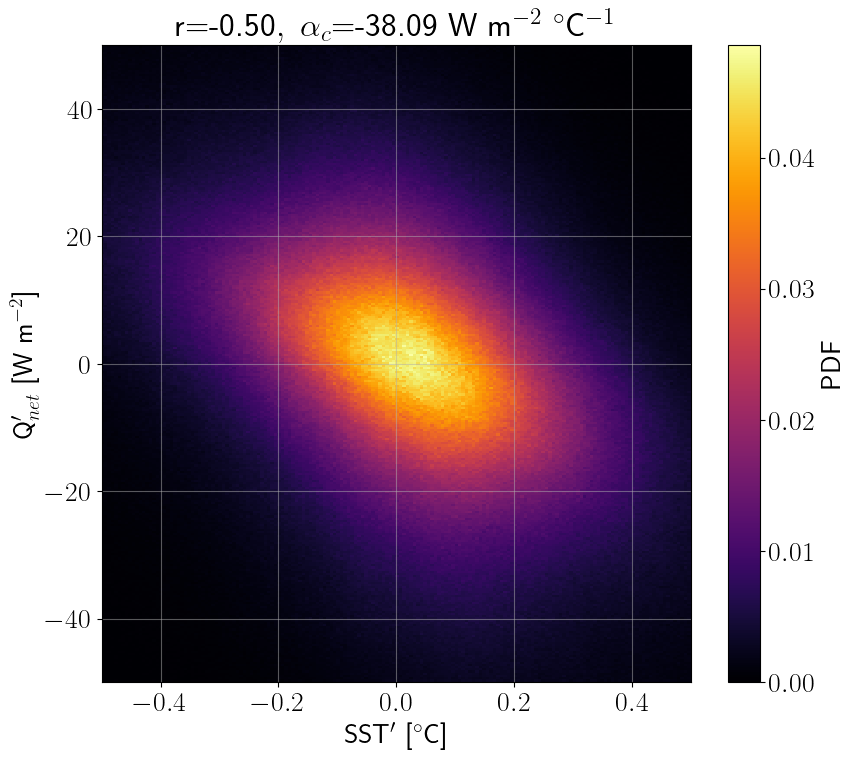

In [19]:
plt.figure(figsize=(9,8))
# plt.hist2d(np.ravel(rtf_f),np.ravel(rqf_f),bins=1000,density=True,norm=mpl.colors.LogNorm(),cmap='inferno')
plt.hist2d(np.ravel(rtf_f),np.ravel(rqf_f),bins=1000,density=True,norm=mcolors.PowerNorm(1),cmap='inferno')
# plt.colorbar()

plt.grid(alpha=0.5)
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}$C]',fontsize=20,fontweight='bold')
plt.ylabel(r'Q$_{net}^{\prime}$ [W m$^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'r'+'={0:.2f}'.format(np.corrcoef(np.ravel(rtf_f),np.ravel(rqf_f))[0][1])+ r'$,\,\,\alpha_c$={0:.2f}'.format(np.polyfit(np.ravel(rtf_f),np.ravel(rqf_f),deg=1)[0]) 
          +r' W m$^{-2}$ $^{\circ}$C$^{-1}$')
# plt.colorbar(ticks=[0.0001,0.001,0.01,0.1,0.2],label='PDF')
plt.colorbar(label='PDF')

plt.xlim(-0.5,0.5)
plt.ylim(-50,50)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/total_scatter_SSTx(net)_prime_CROCO_Shflx{0}km.png'.format(50))


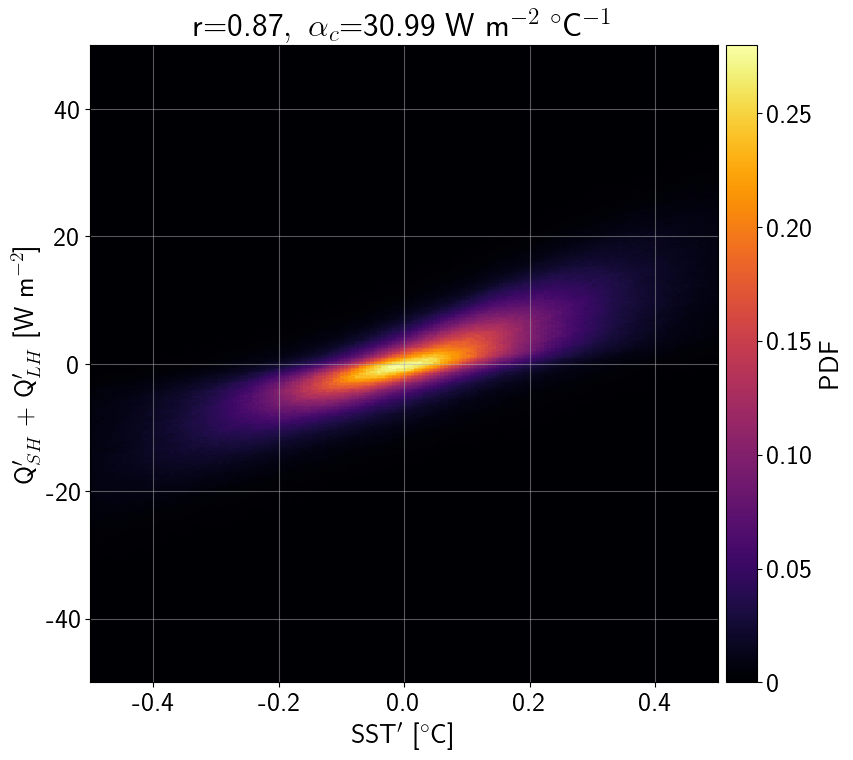

In [91]:
plt.figure(figsize=(9,8))
# plt.hist2d(np.ravel(rtf_f),np.ravel(rqf_f),bins=1000,density=True,norm=mpl.colors.LogNorm(),cmap='inferno')
plt.hist2d(np.ravel(rtf_f),np.ravel(rqhf_f),bins=1000,density=True,norm=mcolors.PowerNorm(1),cmap='inferno')
# plt.colorbar()

plt.grid(alpha=0.5)
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}$C]',fontsize=20,fontweight='bold')
plt.ylabel(r'Q$_{SH}^{\prime}$ + Q$_{LH}^{\prime}$ [W m$^{-2}$]',fontsize=20,fontweight='bold')

plt.title(r'r'+'={0:.2f}'.format(np.corrcoef(np.ravel(rtf_f),np.ravel(rqhf_f))[0][1])+ r'$,\,\,\alpha_c$={0:.2f}'.format(np.polyfit(np.ravel(rtf_f),np.ravel(rqhf_f),deg=1)[0]) 
          +r' W m$^{-2}$ $^{\circ}$C$^{-1}$')
# plt.colorbar(ticks=[0.0001,0.001,0.01,0.1,0.2],label='PDF')
cb=plt.colorbar(label='PDF',ticks=np.arange(0,0.3,0.05),pad=0.01)
cb.ax.set_yticklabels(['0','0.05','0.10','0.15','0.20','0.25'])
plt.xlim(-0.5,0.5)
plt.ylim(-50,50)
plt.yticks(np.arange(-40,60,20),labels=np.arange(-40,60,20).astype(str))
plt.xticks(np.arange(-0.4,0.6,0.2),labels=np.round(np.arange(-0.4,0.6,0.2),3).astype(str))

plt.tight_layout()

# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/total_scatter_SSTx(net)_prime_WRF_LH+SH{0}km.png'.format(50),dpi=400)
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/total_scatter_SSTx(net)_prime_WRF_LH+SH{0}km.png'.format(50),dpi=400)


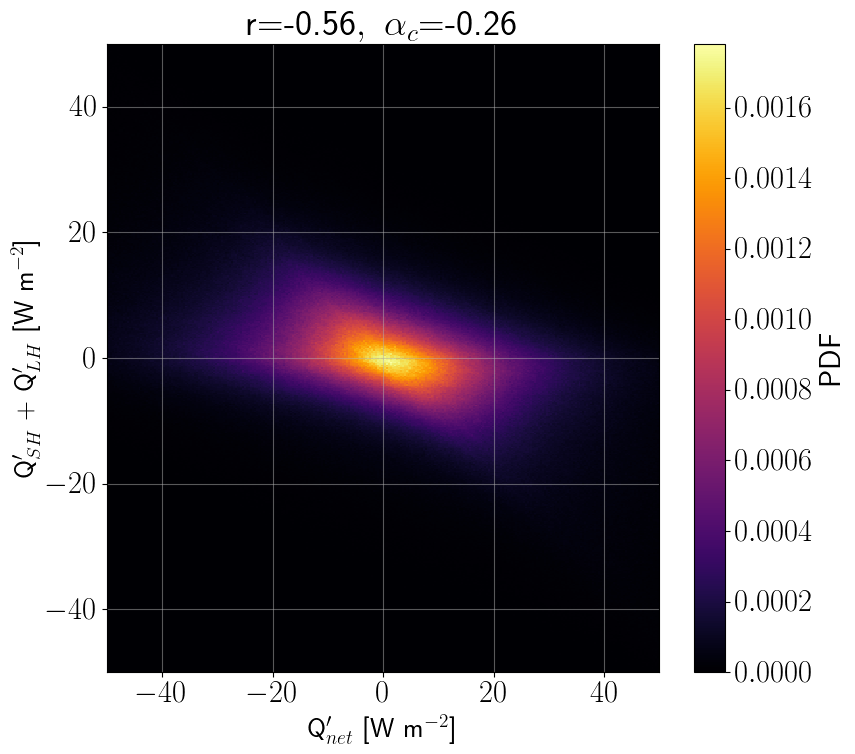

In [38]:
plt.figure(figsize=(9,8))
# plt.hist2d(np.ravel(rtf_f),np.ravel(rqf_f),bins=1000,density=True,norm=mpl.colors.LogNorm(),cmap='inferno')
plt.hist2d(np.ravel(rqf_f),np.ravel(rqhf_f),bins=1000,density=True,norm=mcolors.PowerNorm(1),cmap='inferno')
# plt.colorbar()

plt.grid(alpha=0.5)
plt.xlabel(r'Q$_{net}^{\prime}$ [W m$^{-2}$]',fontsize=20,fontweight='bold')
plt.ylabel(r'Q$_{SH}^{\prime}$ + Q$_{LH}^{\prime}$ [W m$^{-2}$]',fontsize=20,fontweight='bold')

plt.title(r'r'+'={0:.2f}'.format(np.corrcoef(np.ravel(rqf_f),np.ravel(rqhf_f))[0][1])+ r'$,\,\,\alpha_c$={0:.2f}'.format(np.polyfit(np.ravel(rqf_f),np.ravel(rqhf_f),deg=1)[0]) 
          +r'')
# plt.colorbar(ticks=[0.0001,0.001,0.01,0.1,0.2],label='PDF')
plt.colorbar(label='PDF')

plt.xlim(-50,50)
plt.ylim(-50,50)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/(net)_prime_CROCO_Shflx_(net)_prime_WRF_LH+SH{0}km.png'.format(50))


In [56]:
a_r_f,b_r_f=np.polyfit(r_tf_f,(r_sh_f_f+r_lh_f_f),deg=1)
a_r_sm,b_r_sm=np.polyfit(r_tf_sm,(r_sh_f_sm+r_lh_f_sm),deg=1)

In [58]:
a_r_tot,b_r_tot=np.polyfit((r_tf_f+r_tf_sm),(r_sh_f_sm+r_lh_f_sm+r_sh_f_f+r_lh_f_f),deg=1)

# $\alpha (t)$

In [67]:
b_t_filtered.mean()

0.05199898444629749

In [68]:
alpha_t_filtered.mean()

29.605105103610626

In [66]:
alpha_t_filtered= np.array([np.polyfit(rtf_f[dayss],rqf_f[dayss],deg=1)[0] for dayss in np.arange(rtf_f.shape[0])])
b_t_filtered= np.array([np.polyfit(rtf_f[dayss],rqf_f[dayss],deg=1)[1] for dayss in np.arange(rtf_f.shape[0])])


pearsonr_t_filtered= np.array([np.corrcoef(rtf_f[dayss],rqf_f[dayss])[0][1] for dayss in np.arange(rtf_f.shape[0])])

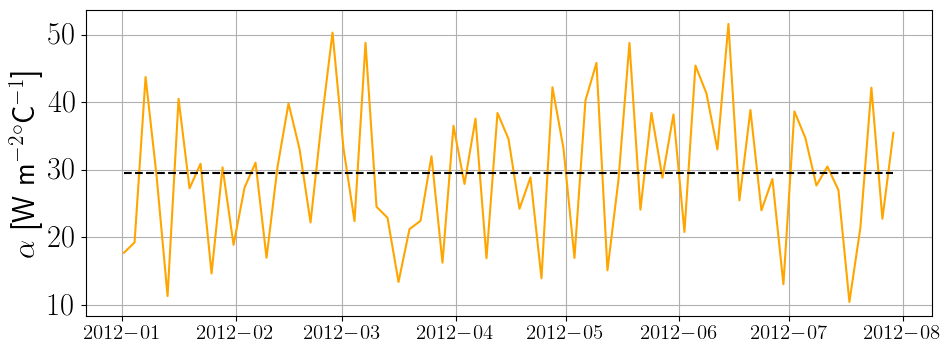

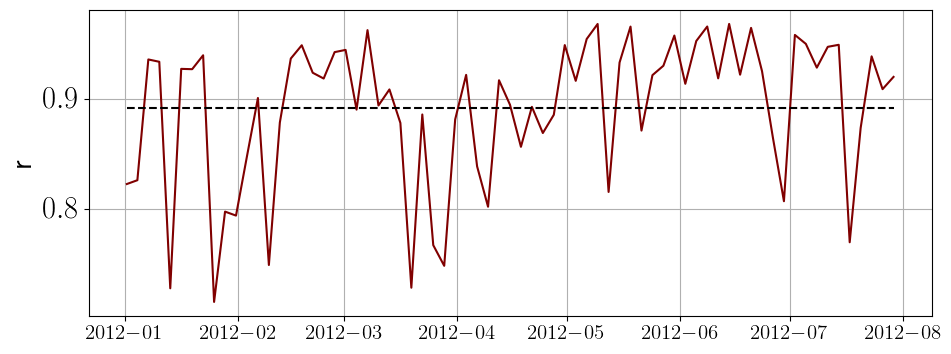

In [69]:
plt.figure(figsize=(10,4))
# plt.plot(tf.dayofyear,np.corrcoef())
plt.plot(timer[::tdec],alpha_t_filtered,color='orange')
plt.plot(timer[::tdec],np.zeros(alpha_t_filtered.shape)+np.nanmean(alpha_t_filtered),'--',color='black')
# plt.xlabel('Days')
plt.ylabel(r'$\alpha$ [W m$^{-2}$$^{\circ}$C$^{-1}$]')
plt.xticks(fontsize=15)
plt.tight_layout()
plt.grid()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/alpha(t)_(SH+LH)_scale{0}km.png'.format(scal_i))

plt.figure(figsize=(10,4))
# plt.plot(tf.dayofyear,np.corrcoef())
plt.plot(timer[::tdec],pearsonr_t_filtered,color='maroon')
plt.plot(timer[::tdec],np.zeros(pearsonr_t_filtered.shape)+np.nanmean(pearsonr_t_filtered),'--',color='black')
# plt.xlabel('Days')
plt.ylabel(r'r')
plt.xticks(fontsize=15)
plt.tight_layout()
plt.grid()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/pearson_r(t)_(SH+LH)_scale{0}km.png'.format(scal_i))

In [70]:
np.corrcoef(np.ravel(rtf_f),np.ravel(rqf_f))[0][1]

0.8814696646556063

# $\alpha \times \lambda$

### Fixed day

In [ ]:
# %%time
# scales_number=[10,30,50,70,90,100]    
# day_i=48

# alpha_f_scal=[]
# pearsonr_f_scal=[]
# alpha_sm_scal=[]
# pearsonr_sm_scal=[]
# dec=2
# for scal in scales_number:    
    
#     grid_croco,scale_radius,scale_circ,scale_areasum=area_filter(lon=tf[:,::dec,::dec].nav_lon_rho,
#                                   lat=tf[:,::dec,::dec].nav_lat_rho,
#                                   filter_scale=scal,dim_x='x_rho',dim_y='y_rho')


#     tf_sm=apply_area_filter(tf[day_i][::dec,::dec],gs=grid_croco,
#                             radius=scale_radius,circ=scale_circ,Asum=scale_areasum)


#     qf_sm=apply_area_filter(qf[day_i][::dec,::dec],gs=grid_croco,
#                             radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

#     r_tf_sm=tf_sm.data[~np.isnan(tf_sm.data)]
#     r_qf_sm=qf_sm.data[~np.isnan(qf_sm.data)]


#     r_tf_f=(tf[day_i][::dec,::dec]-tf_sm).data[~np.isnan(tf_sm.data)]
#     r_qf_f=(qf[day_i][::dec,::dec]-qf_sm).data[~np.isnan(qf_sm.data)]
    
#     alpha_f_scal.append(np.polyfit(r_tf_f,r_qf_f,deg=1)[0])
#     pearsonr_f_scal.append(np.corrcoef(r_tf_f,r_qf_f)[0][1])
#     alpha_sm_scal.append(np.polyfit(r_tf_sm,r_qf_sm,deg=1))
#     pearsonr_sm_scal.append(np.corrcoef(r_tf_sm,r_qf_sm)[0][1])





CPU times: user 2min 42s, sys: 3min 35s, total: 6min 17s
Wall time: 6min 17s


### Multiple days

In [1]:
%%time
scales_number=[10,30,50,70,90,100]    
dayray=np.arange(1,4,1)

alpha_f_scal=[]
pearsonr_f_scal=[]
alpha_sm_scal=[]
pearsonr_sm_scal=[]

tf_sm=tf[dayray,::dec,::dec].copy()
qf_sm=qf[dayray,::dec,::dec].copy()


dec=2
for scal in scales_number:    
    
    grid_croco,scale_radius,scale_circ,scale_areasum=area_filter(lon=tf[0,::dec,::dec].nav_lon_rho,
                                  lat=tf[0,::dec,::dec].nav_lat_rho,
                                  filter_scale=scal,dim_x='x_rho',dim_y='y_rho')

    
    counter=0
    for tms in dayray:    
        tf_sm[counter,:,:]=apply_area_filter(tf[tms][::dec,::dec],gs=grid_croco,
                                radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

        qf_sm[counter,:,:]=apply_area_filter(qf[tms][::dec,::dec],gs=grid_croco,
                                radius=scale_radius,circ=scale_circ,Asum=scale_areasum)
        counter+=1

    r_tf_sm=tf_sm.data[~np.isnan(tf_sm.data)]
    r_qf_sm=qf_sm.data[~np.isnan(qf_sm.data)]


    r_tf_f=(tf[dayray,::dec,::dec]-tf_sm).data[~np.isnan(tf_sm.data)]
    r_qf_f=(qf[dayray,::dec,::dec]-qf_sm).data[~np.isnan(qf_sm.data)]

    alpha_f_scal.append(np.polyfit(r_tf_f,r_qf_f,deg=1)[0])
    pearsonr_f_scal.append(np.corrcoef(r_tf_f,r_qf_f)[0][1])
    alpha_sm_scal.append(np.polyfit(r_tf_sm,r_qf_sm,deg=1))
    pearsonr_sm_scal.append(np.corrcoef(r_tf_sm,r_qf_sm)[0][1])



NameError: name 'np' is not defined

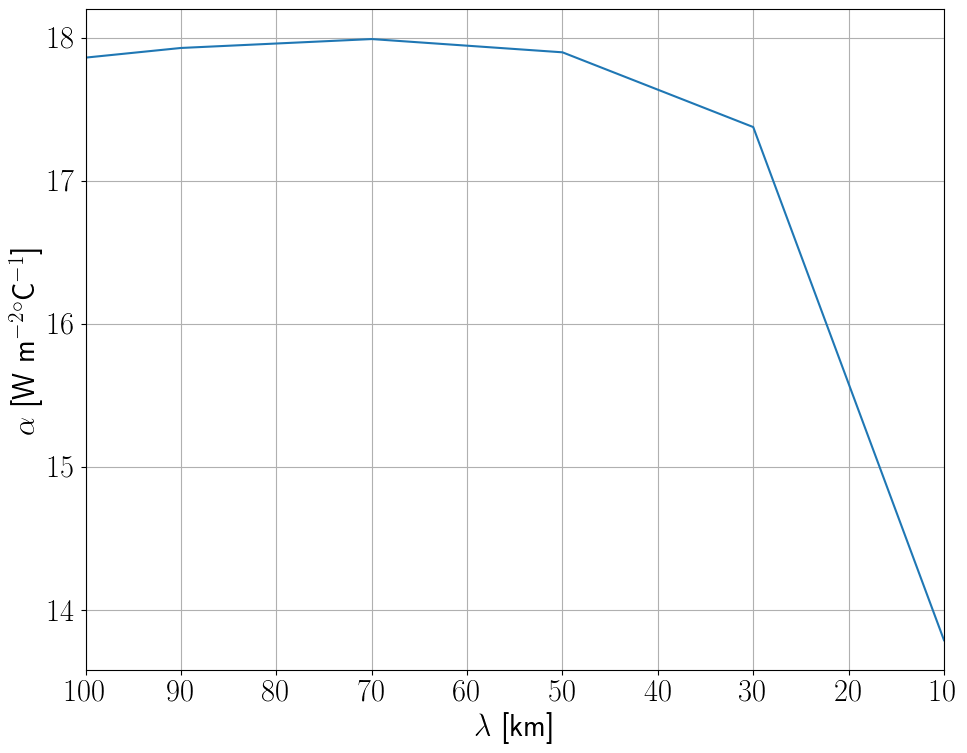

In [111]:
plt.figure(figsize=(10,8))
plt.plot(np.array(scales_number),alpha_f_scal)
plt.ylabel(r'$\alpha$ [W m$^{-2}$$^{\circ}$C$^{-1}$]')
plt.xlabel(r'$\lambda$ [km]')
plt.xlim(np.array(scales_number).max(),np.array(scales_number).min())
plt.grid()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_alpha_x_lamdba_day.png'.format(dayray))

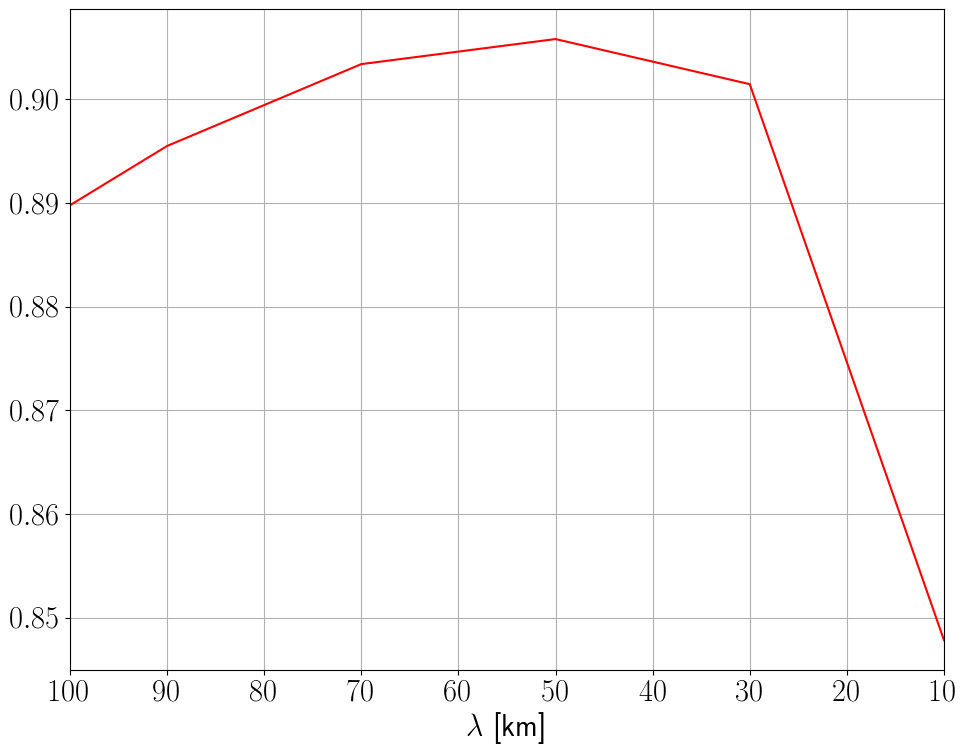

In [112]:
plt.figure(figsize=(10,8))
plt.plot(np.array(scales_number),pearsonr_f_scal,color='red')
# plt.ylabel(r'$\alpha$ [W m$^{-2}$$^{\circ}$C$^{-1}$]')
plt.xlabel(r'$\lambda$ [km]')
plt.xlim(np.array(scales_number).max(),np.array(scales_number).min())
plt.grid()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_correlation_x_lamdba_day.png'.format(day_i))